# WWT Data Visualization : Galactic Center data sets

## imports

In [3]:
from wwt_data_formats import imageset, folder, place, write_xml_doc
from PIL import Image
from astropy import coordinates, units as u
import pyavm

/home/t.yoo/anaconda3/lib/python3.9/site-packages/pyavm/avm.py:629: UserWarning: no shape specified, so Spatial.ReferenceDimension will not be set
  warnings.warn("no shape specified, so Spatial.ReferenceDimension will not be set")

Bad key verbose.level in file pubfiguresrc, line 301 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


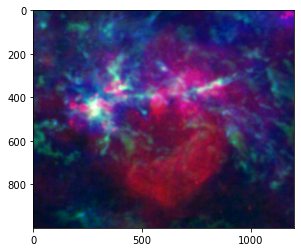

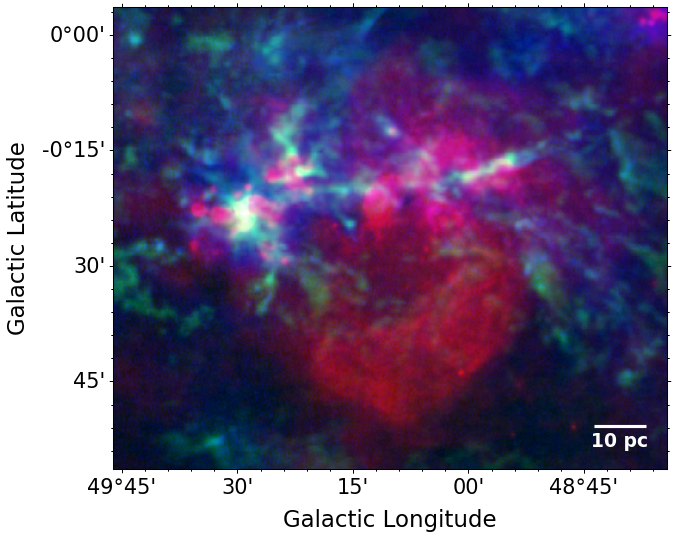

In [4]:
import os
from astropy import units as u
import aplpy
import numpy as np
import copy
import matplotlib
from astropy.io import fits
from astropy import wcs
import reproject
import pylab as pl
import PIL
from PIL import ImageEnhance

import os
b1 = fits.open('AG-Laboca-Planck.49.5.fits')
b2 = fits.open('W51_90cm_CDBB.fits')[0]
b3 = fits.open('grs_13CO_max_30to90kms.fits')

hdr = fits.Header.fromtextfile('hdr4096.hdr')

b1d,_ = reproject.reproject_interp(b1, hdr)
b2d,_ = reproject.reproject_interp((b2.data[0][0], wcs.WCS(b2.header).celestial), hdr)
b3d,_ = reproject.reproject_interp(b3, hdr)


def linearize(x, xmin=None, xmax=None, truncate=True):
    if np.isscalar(x):
        return x
    else:
        if xmin is None:
            xmin = np.nanmin(x)
        if xmax is None:
            xmax = np.nanmax(x)
        if truncate:
            x = np.copy(x)
            x[x<xmin] = xmin
            x[x>xmax] = xmax
        return ((x-xmin)/(xmax-xmin))

def logscale(arr, logexp=3.0, toint=True, relinearize=True, **kwargs):
    linarr = linearize(arr, **kwargs)
    if logexp is None:
        logarr = linarr
    else:
        logarr = np.log10(linarr * 10**logexp + 1)
    if relinearize:
        return linearize(logarr)
    elif toint:
        lla = linearize(logarr)*255
        return lla.astype('uint8')
    else:
        return logarr

def expscale(arr, exp=2, toint=True, **kwargs):
    linarr = linearize(arr, **kwargs)
    if toint:
        lla = linearize(linarr**exp)*255
        return lla.astype('uint8')
    else:
        return linarr**exp


red = linearize(b2d, xmin=-0.05, xmax=0.2) * 0.75 + linearize(b2d, xmin=0.2, xmax=0.7)*0.25
#red = linearize(b2d, xmin=0.01, xmax=0.2)
green = (linearize(b3d, 0, 7))
blue = linearize(b1d,0,0.5) * 0.5 + logscale(b1d, xmin=0.5, xmax=50, toint=False)*0.5
#blue = logscale(b1d, xmin=0.10, xmax=10, toint=False)

rgb = np.array([red,green,blue]).T.swapaxes(0,1)
slices = slice(300,1300), slice(400,1600), slice(None) #[300:1300,400:1600]
rgb_crop = rgb[slices]

mywcs = wcs.WCS(hdr)[slices[:2]]
avm = pyavm.AVM.from_wcs(mywcs)

outfn = "RGB_90cm_CO_ATLASGAL.png"
im = PIL.Image.fromarray((rgb_crop*255).astype('uint8')[::-1,:])
im.save(outfn)
avm.embed(outfn, outfn)

pl.figure(1).clf()
pl.imshow(im)

pl.matplotlib.rc_file('pubfiguresrc')

pl.figure(2).clf()
FF = aplpy.FITSFigure(outfn, figure=pl.figure(2))
FF.show_rgb(outfn)
#FF.set_tick_labels_format('dd.d','dd.d')
FF.save('aplpy_'+outfn)

FF.add_scalebar(((10*u.pc)/(5.1*u.kpc)*u.radian).to(u.deg).value)
FF.scalebar.set_label("10 pc")
FF.scalebar.set_font_size(18)
FF.scalebar.set_font_weight('bold')
FF.scalebar.set_color('w')
FF.scalebar.set_linewidth(3)
FF.save('aplpy_scalebar_'+outfn)

In [1]:
basepath = '/orange/adamginsburg/web/public/jwst/brick_2221/'

In [5]:
fld = folder.Folder()
fld.browseable = True
fld.group = 'Explorer'
fld.name = 'The Brick'
fld.searchable = True
fld.thumbnail = 'http://data.rc.ufl.edu/pub/adamginsburg/jwst/brick_2221/BrickJWST_merged_longwave_narrowband_lighter.png'
fld.type = 'SKY'
fld.children = []

for name, imgname in {"Starry Brick F405+F466": 'BrickJWST_merged_longwave_narrowband_withstars.png',
                      "Starless Brick F405+466": 'BrickJWST_merged_longwave_narrowband_lighter.png',
                      "Brick: JWST and ALMA": 'BrickALMAJWST_WhiteHaze.png',
                      "Brick: Spitzer": "BrickSpitzer_RGB_I421.png",
                      "Cloud C: F405N+F466N": "/orange/adamginsburg/jwst/cloudc/images/cloudcJWST_merged_R-F466N_B-F405N_rotated.png",
                        }.items():
    
    if 'cloudc' in imgname:
        cloudc = 'cloudc/'
        imfn = imgname
        imgname = os.path.basename(imgname)
    else:
        cloudc = ''
        imfn = f'{basepath}/{imgname}'
    img = Image.open(imfn)
    img.thumbnail((100, 100))
    img.save(imfn.replace(".png", "_thumbnail.png"))
    img = Image.open(imfn)
    
    avm = pyavm.AVM.from_image(imfn)
    ww = avm.to_wcs()
    height, width, _ = np.array(img).shape
    
    pl = place.Place()
    pl.name = name
    pl.thumbnail = f'http://data.rc.ufl.edu/pub/adamginsburg/jwst/brick_2221/{cloudc}{imgname.replace(".png", "_thumbnail.png")}'
    pl.constellation = 'SAGITTARIUS'
    pl.data_set_type = 'SKY'
    pl.opacity = 100
    pl.zoom_level = 2
    
    imgset = imageset.ImageSet()
    imgset.set_position_from_wcs(ww.to_header(), width=width, height=height, place=pl, fov_factor=2.5)
    imgset.url = f'http://data.rc.ufl.edu/pub/adamginsburg/jwst/brick_2221/{cloudc}{imgname}'
    imgset.thumbnail_url = f'http://data.rc.ufl.edu/pub/adamginsburg/jwst/brick_2221/{cloudc}{imgname.replace(".png", "_thumbnail.png")}'
    imgset.bottoms_up = False
    imgset.rotation_deg = 90
    imgset.band_pass = "INFRARED"
    imgset.offset_x = width/2
    imgset.offset_y = height/2
    #observed_xml = imgset.to_xml()
    
    pl.ra_hr = imgset.center_x / 15
    pl.dec_deg = imgset.center_y
    
    pl.foreground_image_set = imgset
    fld.children.append(pl)
    pl.zoom_level = 1

with open('/orange/adamginsburg/web/public/jwst/brick_2221/brick.wtml', 'w') as fh:
    write_xml_doc(fld.to_xml(), dest_stream=fh)

PermissionError: [Errno 13] Permission denied: '/orange/adamginsburg/web/public/jwst/brick_2221//BrickJWST_merged_longwave_narrowband_withstars_thumbnail.png'

In [14]:
url = 'https://www.adamgginsburg.com/images/gc/gc_fullres_6_small.jpg'
turl = 'https://www.adamgginsburg.com/images/gc/gc_winner_800x800.jpg'
content = requests.get(url).content
fh = BytesIO(content)
img = Image.open(fh)

tf = tempfile.NamedTemporaryFile()
with open(tf.name, 'wb') as fh_:
    fh_.write(content)
    avm = pyavm.AVM.from_image(tf.name)

ww = avm.to_wcs()
height, width, _ = np.array(img).shape

    
pl = place.Place()
pl.name = 'Galactic Center in the Radio and IR'
if turl:
    pl.thumbnail = turl
pl.constellation = 'SAGITTARIUS'
pl.data_set_type = 'SKY'
pl.opacity = 100

imgset = imageset.ImageSet()
#imgset.set_position_from_wcs(ww.to_header(), width=width, height=height, place=pl, fov_factor=2.5)
cen = ww.pixel_to_world(width/2, height/2)
imgset.center_x = cen.fk5.ra.deg
imgset.center_y = cen.fk5.dec.deg
imgset.projection = 'SKY_IMAGE'
imgset.base_degrees_per_tile = (ww.proj_plane_pixel_area()**0.5).value


imgset.file_type = '.jpg'
imgset.url = url
if turl:
    imgset.thumbnail_url = turl
imgset.bottoms_up = False

offcen = ww.pixel_to_world(width/2, height)
posang = coordinates.position_angle(cen.fk5.ra, cen.fk5.dec, offcen.fk5.ra, offcen.fk5.dec)

imgset.rotation_deg = posang.to(u.deg).value
imgset.band_pass = "RADIO"
imgset.offset_x = width/2
imgset.offset_y = height/2
#observed_xml = imgset.to_xml()

pl.ra_hr = imgset.center_x / 15
pl.dec_deg = imgset.center_y

pl.foreground_image_set = imgset
fld.children.append(pl)
pl.zoom_level = 10
#pl.rotation_deg = posang.to(u.deg).value

with open('/orange/adamginsburg/web/public/jwst/brick_2221/brick_gc.wtml', 'w') as fh:
    write_xml_doc(fld.to_xml(), dest_stream=fh)
print('done')

done


In [15]:
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 933120000

url = 'https://data.rc.ufl.edu/pub/adamginsburg/ACES/MUSTANG_TENS_noaxes.png'
imfn = '/orange/adamginsburg/web/public/ACES/MUSTANG_TENS_noaxes.png'
if not os.path.exists(imfn.replace(".png", "_thumbnail.png")):
    img = Image.open(imfn)
    img.thumbnail((100, 100))
    img.save(imfn.replace(".png", "_thumbnail.png"))
turl = 'https://data.rc.ufl.edu/pub/adamginsburg/ACES/MUSTANG_TENS_noaxes_thumbnail.png'
img = Image.open(imfn)

avm = pyavm.AVM.from_image(imfn)

ww = avm.to_wcs()
height, width, _ = np.array(img).shape

    
pl = place.Place()
pl.name = 'MUSTANG TENS'
if turl:
    pl.thumbnail = turl
pl.constellation = 'SAGITTARIUS'
pl.data_set_type = 'SKY'
pl.opacity = 100

imgset = imageset.ImageSet()
#imgset.set_position_from_wcs(ww.to_header(), width=width, height=height, place=pl, fov_factor=2.5)
cen = ww.pixel_to_world(width/2, height/2)
imgset.center_x = cen.fk5.ra.deg
imgset.center_y = cen.fk5.dec.deg
imgset.projection = 'SKY_IMAGE'
imgset.base_degrees_per_tile = (ww.proj_plane_pixel_area()**0.5).value


print(width, height, imgset.base_degrees_per_tile)
      
imgset.file_type = '.png'
imgset.url = url
if turl:
    imgset.thumbnail_url = turl
imgset.bottoms_up = False

offcen = ww.pixel_to_world(width/2, height)
posang = coordinates.position_angle(cen.fk5.ra, cen.fk5.dec, offcen.fk5.ra, offcen.fk5.dec)

imgset.rotation_deg = posang.to(u.deg).value
imgset.band_pass = "RADIO"
imgset.offset_x = width/2
imgset.offset_y = height/2
#observed_xml = imgset.to_xml()

pl.ra_hr = imgset.center_x / 15
pl.dec_deg = imgset.center_y

pl.foreground_image_set = imgset
fld.children.append(pl)
pl.zoom_level = 10
#pl.rotation_deg = posang.to(u.deg).value

with open('/orange/adamginsburg/web/public/jwst/brick_2221/brick_gc.wtml', 'w') as fh:
    write_xml_doc(fld.to_xml(), dest_stream=fh)
print('done')

4288 4175 0.0002777777777778001
done


In [16]:
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 933120000

url = 'https://data.rc.ufl.edu/pub/adamginsburg/ACES/MUSTANG_12m_feather_noaxes.png'
imfn = '/orange/adamginsburg/web/public/ACES/MUSTANG_12m_feather_noaxes.png'
if not os.path.exists(imfn.replace(".png", "_thumbnail.png")):
    img = Image.open(imfn)
    img.thumbnail((100, 100))
    img.save(imfn.replace(".png", "_thumbnail.png"))
turl = 'https://data.rc.ufl.edu/pub/adamginsburg/ACES/MUSTANG_12m_feather_noaxes_thumbnail.png'
img = Image.open(imfn)

avm = pyavm.AVM.from_image(imfn)

ww = avm.to_wcs()
height, width, _ = np.array(img).shape

    
pl = place.Place()
pl.name = 'ACES and TENS (png)'
if turl:
    pl.thumbnail = turl
pl.constellation = 'SAGITTARIUS'
pl.data_set_type = 'SKY'
pl.opacity = 100

imgset = imageset.ImageSet()
#imgset.set_position_from_wcs(ww.to_header(), width=width, height=height, place=pl, fov_factor=2.5)
cen = ww.pixel_to_world(width/2, height/2)
imgset.center_x = cen.fk5.ra.deg
imgset.center_y = cen.fk5.dec.deg
imgset.projection = 'SKY_IMAGE'
imgset.base_degrees_per_tile = (ww.proj_plane_pixel_area()**0.5).value


print(width, height, imgset.base_degrees_per_tile)
      
imgset.file_type = '.png'
imgset.url = url
if turl:
    imgset.thumbnail_url = turl
imgset.bottoms_up = False

offcen = ww.pixel_to_world(width/2, height)
posang = coordinates.position_angle(cen.fk5.ra, cen.fk5.dec, offcen.fk5.ra, offcen.fk5.dec)

imgset.rotation_deg = posang.to(u.deg).value
imgset.band_pass = "RADIO"
imgset.offset_x = width/2
imgset.offset_y = height/2
#observed_xml = imgset.to_xml()

pl.ra_hr = imgset.center_x / 15
pl.dec_deg = imgset.center_y

pl.foreground_image_set = imgset
fld.children.append(pl)
pl.zoom_level = 10
#pl.rotation_deg = posang.to(u.deg).value

with open('/orange/adamginsburg/web/public/jwst/brick_2221/brick_gc.wtml', 'w') as fh:
    write_xml_doc(fld.to_xml(), dest_stream=fh)
print('done')

18620 10200 5.555555554300004e-05
done


In [17]:
#acestens = place.Place.from_file("/orange/adamginsburg/web/public/ACES/MUSTANG_Feather/index_rel.wtml")
acestens = folder.Folder.from_file("/orange/adamginsburg/web/public/ACES/MUSTANG_Feather/index_rel.wtml")
acestens.children[0].name = 'ACES+TENS (toasty)'
fld.children.extend(acestens.children)
with open('/orange/adamginsburg/web/public/jwst/brick_2221/brick_gc.wtml', 'w') as fh:
    write_xml_doc(fld.to_xml(), dest_stream=fh)

In [18]:
acestens.children[0].name

'ACES+TENS (toasty)'

## Add MEERKAT

In [19]:
meerplace = place.Place.from_text("""
  <Place Angle="0" AngularSize="0" DataSetType="Sky" Dec="-29.221836082925606" Magnitude="0" Name="MeerKAT_Galactic_Centre_1284MHz-StokesI_tiled" Opacity="100" RA="17.758054459614392" Rotation="0" ZoomLevel="32.8091977224">
    <ForegroundImageSet>
      <ImageSet BandPass="Visible" BaseDegreesPerTile="5.006229504" BaseTileLevel="0" BottomsUp="False" CenterX="266.366790598" CenterY="-29.2213778092" DataMax="0.7066638163374066" DataMin="-0.00125779378158081" DataSetType="Sky" ElevationModel="False" FileType=".fits" Generic="False" Name="MeerKAT_Galactic_Centre_1284MHz-StokesI_tiled" OffsetX="-0.003513894" OffsetY="-0.000458334" PixelCutHigh="0.004745915678209696" PixelCutLow="-0.0003184565157501922" Projection="Tan" QuadTreeMap="" Rotation="-0" Sparse="True" StockSet="False" TileLevels="6" Url="http://data1.wwtassets.org/packages/2022/01_meerkat_gc/MeerKAT_Galactic_Centre_1284MHz-StokesI_tiled/{1}/{3}/{3}_{2}.fits" WidthFactor="2">
        <ThumbnailUrl />
		<Credits>I. Heywood, SARAO</Credits>
		<CreditsUrl>https://archive-gw-1.kat.ac.za/public/repository/10.48479/fyst-hj47/index.html</CreditsUrl>
      </ImageSet>
    </ForegroundImageSet>
  </Place>
""")
fld.children.append(meerplace)
with open('/orange/adamginsburg/web/public/jwst/brick_2221/brick_gc.wtml', 'w') as fh:
    write_xml_doc(fld.to_xml(), dest_stream=fh)

## Verify that the file was written

In [20]:
cat /orange/adamginsburg/web/public/jwst/brick_2221/brick_gc.wtml

<?xml version='1.0' encoding='UTF-8'?>
<Folder Browseable="True" Group="Explorer" Name="The Brick" Searchable="True" Thumbnail="http://data.rc.ufl.edu/pub/adamginsburg/jwst/brick_2221/BrickJWST_merged_longwave_narrowband_lighter.png" Type="Sky">
  <Place Angle="0" AngularSize="0" Constellation="SGR" DataSetType="Sky" Dec="-28.712968795984" Magnitude="0" Name="Starry Brick F405+F466" Opacity="100" RA="17.769038618397335" Rotation="0" Thumbnail="http://data.rc.ufl.edu/pub/adamginsburg/jwst/brick_2221/BrickJWST_merged_longwave_narrowband_withstars_thumbnail.png" ZoomLevel="1">
    <ForegroundImageSet>
      <ImageSet BandPass="IR" BaseDegreesPerTile="1.74737238791e-05" BaseTileLevel="0" BottomsUp="False" CenterX="266.53557927596" CenterY="-28.712968795984" DataSetType="Sky" ElevationModel="False" FileType=".png" Generic="False" Name="" OffsetX="2862.5" OffsetY="1175" Projection="SkyImage" QuadTreeMap="" Rotation="90" Sparse="True" StockSet="False" TileLevels="0" Url="http://data.rc.ufl.ed

https://worldwidetelescope.org/webclient/?wtml=https://data.rc.ufl.edu/pub/adamginsburg/jwst/brick_2221/brick.wtml#/place=Open_Collections.The_Brick.3&imagery=GLIMPSE_360&ra=17.76904&dec=-28.71300&fov=0.10185

https://worldwidetelescope.org/webclient/?wtml=https://data.rc.ufl.edu/pub/adamginsburg/jwst/brick_2221/brick_gc.wtml#/place=Open_Collections.The_Brick.3&imagery=GLIMPSE_360&ra=17.76904&dec=-28.71300&fov=0.10185

# Use ACES generalized version 

In [25]:
ls /orange/adamginsburg/web/public/jwst/brick_2221/

BlueStars_on_RGB.png
BlueStars_on_RGB_stars.png
BrAExcessStars_on_RGB.png
brick2.wtml
BrickALMAJWST_BrownHaze_InsetZooms2.png
BrickALMAJWST_BrownHaze_InsetZooms.png
BrickALMAJWST_BrownHaze_InsetZooms_withOBstars.png
BrickALMAJWST_BrownHaze.png
BrickALMAJWST_longwave_RGB.png
BrickALMAJWST_longwave_RGB_unrotated.png
BrickALMAJWST_PurpleHaze.png
BrickALMAJWST_WhiteHaze.png
BrickALMAJWST_WhiteHaze_thumbnail.png
brick_cloudc_gc.wtml
brick_gc.wtml
BrickJWST_1182p2221_212_200_182.png
BrickJWST_1182p2221_212_200_187.png
BrickJWST_1182p2221_405_200_182.png
BrickJWST_1182p2221_405_200_187.png
BrickJWST_1182p2221_405_356_212.png
BrickJWST_1182p2221_444_405_356.png
BrickJWST_1182p2221_444_410_356.png
BrickJWST_1182p2221_466_444_356.png
BrickJWST_1182p2221_466_444_356_thumbnail.png
BrickJWST_1182p2221_466_444_405.png
BrickJWST_1182p2221_466_444_410.png
BrickJWST_212-187-182_RGB_unrotated.png
BrickJWST_ContSub_LongWave.png
BrickJWSTLong_InsetZooms2.png
BrickJWSTLong_InsetZooms3.png
BrickJWSTLong_Ins

In [33]:
avm.to_wcs()

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 266.5356389808593 -28.712998625026 
CRPIX : 2829.531214097682 1167.45507920672 
NAXIS : 0  0

In [26]:
import pyavm
for fn in glob.glob("/orange/adamginsburg/web/public/jwst/brick_2221/*png"):
    try:
        avm = pyavm.AVM.from_image(fn)
        avm.to_wcs()
        print(fn, 'success')
    except Exception as ex:
        print(fn, ex)

/orange/adamginsburg/web/public/jwst/brick_2221/BrickJWST_1182p2221_466_444_356.png success
/orange/adamginsburg/web/public/jwst/brick_2221/BrickJWST_merged_longwave_narrowband_withstars_thumbnail.png No XMP packet present in file
/orange/adamginsburg/web/public/jwst/brick_2221/BrickSpitzer_RGB_I421_thumbnail.png No XMP packet present in file
/orange/adamginsburg/web/public/jwst/brick_2221/BrickJWST_merged_longwave_narrowband_rotated_withstars.png success
/orange/adamginsburg/web/public/jwst/brick_2221/BrickJWSTLong_InsetZooms2.png No XMP packet present in file
/orange/adamginsburg/web/public/jwst/brick_2221/BlueStars_on_RGB.png No XMP packet present in file
/orange/adamginsburg/web/public/jwst/brick_2221/BrickALMAJWST_BrownHaze.png success
/orange/adamginsburg/web/public/jwst/brick_2221/BrickJWST_merged_longwave_narrowband_withstars_thumbnail_thumbnail.png No XMP packet present in file
/orange/adamginsburg/web/public/jwst/brick_2221/BrickJWST_shortwave_RGB_187_212_182.png success
/ora

In [27]:
ls /orange/adamginsburg/web/public/jwst/brick_2221/BrickJWST_212-187-182_RGB_unrotated.png

/orange/adamginsburg/web/public/jwst/brick_2221/BrickJWST_212-187-182_RGB_unrotated.png


In [28]:
ls -lh /orange/adamginsburg/jwst/brick/analysis/toast_brick.py

-rw-r--r-- 1 adamginsburg adamginsburg 8.6K May 10 11:05 /orange/adamginsburg/jwst/brick/analysis/toast_brick.py


## orientations are wrong

In [1]:
%run /orange/adamginsburg/jwst/brick/analysis/toast_brick.py

Making no-toast index
/orange/adamginsburg/web/public/jwst/brick_2221/BrickJWST_1182p2221_466_444_356.png success
/orange/adamginsburg/web/public/jwst/brick_2221/BrickJWST_merged_longwave_narrowband_rotated_withstars.png success
/orange/adamginsburg/web/public/jwst/brick_2221/BrickJWSTLong_InsetZooms2.png No XMP packet present in file
/orange/adamginsburg/web/public/jwst/brick_2221/BlueStars_on_RGB.png No XMP packet present in file
/orange/adamginsburg/web/public/jwst/brick_2221/BrickALMAJWST_BrownHaze.png success
/orange/adamginsburg/web/public/jwst/brick_2221/BrickJWST_shortwave_RGB_187_212_182.png success
/orange/adamginsburg/web/public/jwst/brick_2221/Spitzer_RGB_I421.png No XMP packet present in file
/orange/adamginsburg/web/public/jwst/brick_2221/BrickJWST_merged_longwave_narrowband_rotated_only405plus466.png success
/orange/adamginsburg/web/public/jwst/brick_2221/BrickJWST_1182p2221_405_200_182.png success
/orange/adamginsburg/web/public/jwst/brick_2221/BrickSpitzer_RGB_I432.png

NameError: name 'indexes' is not defined

In [53]:
toast('/orange/adamginsburg/web/public/jwst/brick_2221/cloudc/cloudcJWST_merged_R-F466N_G-F410M_B-F405N_rotated.png',
      targetdir='/orange/adamginsburg/web/public/jwst/brick_2221/toasts/cloudcJWST_merged_R-F466N_G-F410M_B-F405N_rotated/'
     )

Wrote  /orange/adamginsburg/web/public/jwst/brick_2221/toasts/cloudcJWST_merged_R-F466N_G-F410M_B-F405N_rotated/index.wtml


'/orange/adamginsburg/web/public/jwst/brick_2221/toasts/cloudcJWST_merged_R-F466N_G-F410M_B-F405N_rotated/index.wtml'

In [18]:
toast('/orange/adamginsburg/jwst/brick/images/BrickJWST_212-187-182_RGB_unrotated.png',
      targetdir='/orange/adamginsburg/web/public/jwst/brick_2221/toasts/BrickJWST_212-187-182_RGB_unrotated'
     )

Wrote  /orange/adamginsburg/web/public/jwst/brick_2221/toasts/BrickJWST_212-187-182_RGB_unrotated/index.wtml


'/orange/adamginsburg/web/public/jwst/brick_2221/toasts/BrickJWST_212-187-182_RGB_unrotated/index.wtml'

In [6]:
toast('/orange/adamginsburg/web/public/jwst/brick_2221/BrickJWST_212-187-182_RGB_unrotated.png',
      targetdir='/orange/adamginsburg/web/public/jwst/brick_2221/toasts/BrickJWST_212-187-182_RGB_unrotated'
     )

Wrote  /orange/adamginsburg/web/public/jwst/brick_2221/toasts/BrickJWST_212-187-182_RGB_unrotated/index.wtml


'/orange/adamginsburg/web/public/jwst/brick_2221/toasts/BrickJWST_212-187-182_RGB_unrotated/index.wtml'